# Predict House Prices in Ames, Iowa - Regression Task

**Imports**

In [1]:
import os
import pickle

import numpy as np
import pandas as pd
import pandas_profiling as pp

import matplotlib.pyplot as plt

from sklearn.preprocessing import MinMaxScaler
from sklearn.ensemble import RandomForestRegressor
from sklearn.metrics import r2_score, mean_squared_error, mean_absolute_error

import tensorflow as tf
from tensorflow import keras
from keras.preprocessing.text import Tokenizer
from keras.preprocessing.sequence import pad_sequences
from tensorflow.keras import Model
from tensorflow.keras.layers import Input, Embedding, Flatten, Concatenate, Dense, Dropout
from tensorflow.keras.optimizers import Adam

print(tf.__version__)

2.1.0


Using TensorFlow backend.


**Global variables**

In [2]:
RANDOM_SEED = 42

DATA_PATH = 'data'
MODEL_PATH = 'artifacts'

MAP_PATH = os.path.join(MODEL_PATH, 'feature_maps.pkl')
SCALER_PATH = os.path.join(MODEL_PATH, 'scaler.pkl')
TOKENIZER_PATH = os.path.join(MODEL_PATH, 'tokenizer.pkl')
KERAS_PATH = os.path.join(MODEL_PATH, 'model')
PREDICTION_PATH = os.path.join(MODEL_PATH, 'predictions.pkl')

LABEL = 'SalePrice'
EMB_TEXT = 'emb_text'

**Useful functions**

In [3]:
def pickle_dump(path, obj):
    with open(path, 'wb') as p:
        pickle.dump(obj, p)
        
def pickle_load(path):
    obj = pickle.load(open(path, 'rb'))
    return obj

## Data ingestion

* `train` - (1460 rows, 81 columns) - used for training and evaluating model
* `test` - (1459 rows, 80 columns) - predictions should be generated for this dataset


**Features:**
* SalePrice - the property's sale price in dollars. This is the target variable that you're trying to predict.
* MSSubClass: The building class
* MSZoning: The general zoning classification
* LotFrontage: Linear feet of street connected to property
* LotArea: Lot size in square feet
* Street: Type of road access
* Alley: Type of alley access
* LotShape: General shape of property
* LandContour: Flatness of the property
* Utilities: Type of utilities available
* LotConfig: Lot configuration
* LandSlope: Slope of property
* Neighborhood: Physical locations within Ames city limits
* Condition1: Proximity to main road or railroad
* Condition2: Proximity to main road or railroad (if a second is present)
* BldgType: Type of dwelling
* HouseStyle: Style of dwelling
* OverallQual: Overall material and finish quality
* OverallCond: Overall condition rating
* YearBuilt: Original construction date
* YearRemodAdd: Remodel date
* RoofStyle: Type of roof
* RoofMatl: Roof material
* Exterior1st: Exterior covering on house
* Exterior2nd: Exterior covering on house (if more than one material)
* MasVnrType: Masonry veneer type
* MasVnrArea: Masonry veneer area in square feet
* ExterQual: Exterior material quality
* ExterCond: Present condition of the material on the exterior
* Foundation: Type of foundation
* BsmtQual: Height of the basement
* BsmtCond: General condition of the basement
* BsmtExposure: Walkout or garden level basement walls
* BsmtFinType1: Quality of basement finished area
* BsmtFinSF1: Type 1 finished square feet
* BsmtFinType2: Quality of second finished area (if present)
* BsmtFinSF2: Type 2 finished square feet
* BsmtUnfSF: Unfinished square feet of basement area
* TotalBsmtSF: Total square feet of basement area
* Heating: Type of heating
* HeatingQC: Heating quality and condition
* CentralAir: Central air conditioning
* Electrical: Electrical system
* 1stFlrSF: First Floor square feet
* 2ndFlrSF: Second floor square feet
* LowQualFinSF: Low quality finished square feet (all floors)
* GrLivArea: Above grade (ground) living area square feet
* BsmtFullBath: Basement full bathrooms
* BsmtHalfBath: Basement half bathrooms
* FullBath: Full bathrooms above grade
* HalfBath: Half baths above grade
* BedroomAbvGr: Number of bedrooms above basement level
* KitchenAbvGr: Number of kitchens
* KitchenQual: Kitchen quality
* TotRmsAbvGrd: Total rooms above grade (does not include bathrooms)
* Functional: Home functionality rating
* Fireplaces: Number of fireplaces
* FireplaceQu: Fireplace quality
* GarageType: Garage location
* GarageYrBlt: Year garage was built
* GarageFinish: Interior finish of the garage
* GarageCars: Size of garage in car capacity
* GarageArea: Size of garage in square feet
* GarageQual: Garage quality
* GarageCond: Garage condition
* PavedDrive: Paved driveway
* WoodDeckSF: Wood deck area in square feet
* OpenPorchSF: Open porch area in square feet
* EnclosedPorch: Enclosed porch area in square feet
* 3SsnPorch: Three season porch area in square feet
* ScreenPorch: Screen porch area in square feet
* PoolArea: Pool area in square feet
* PoolQC: Pool quality
* Fence: Fence quality
* MiscFeature: Miscellaneous feature not covered in other categories
* MiscVal: $Value of miscellaneous feature
* MoSold: Month Sold
* YrSold: Year Sold
* SaleType: Type of sale
* SaleCondition: Condition of sale

In [4]:
data = pd.read_csv(os.path.join(DATA_PATH, 'train.csv'), header=0)

In [5]:
data.head(1)

,Id,MSSubClass,MSZoning,LotFrontage,LotArea,Street,Alley,LotShape,LandContour,Utilities,...,PoolArea,PoolQC,Fence,MiscFeature,MiscVal,MoSold,YrSold,SaleType,SaleCondition,SalePrice
0,1,60,RL,65.0,8450,Pave,NaN,Reg,Lvl,AllPub,...,0,NaN,NaN,NaN,0,2,2008,WD,Normal,208500


In [6]:
data.columns.values

array(['Id', 'MSSubClass', 'MSZoning', 'LotFrontage', 'LotArea', 'Street',
       'Alley', 'LotShape', 'LandContour', 'Utilities', 'LotConfig',
       'LandSlope', 'Neighborhood', 'Condition1', 'Condition2',
       'BldgType', 'HouseStyle', 'OverallQual', 'OverallCond',
       'YearBuilt', 'YearRemodAdd', 'RoofStyle', 'RoofMatl',
       'Exterior1st', 'Exterior2nd', 'MasVnrType', 'MasVnrArea',
       'ExterQual', 'ExterCond', 'Foundation', 'BsmtQual', 'BsmtCond',
       'BsmtExposure', 'BsmtFinType1', 'BsmtFinSF1', 'BsmtFinType2',
       'BsmtFinSF2', 'BsmtUnfSF', 'TotalBsmtSF', 'Heating', 'HeatingQC',
       'CentralAir', 'Electrical', '1stFlrSF', '2ndFlrSF', 'LowQualFinSF',
       'GrLivArea', 'BsmtFullBath', 'BsmtHalfBath', 'FullBath',
       'HalfBath', 'BedroomAbvGr', 'KitchenAbvGr', 'KitchenQual',
       'TotRmsAbvGrd', 'Functional', 'Fireplaces', 'FireplaceQu',
       'GarageType', 'GarageYrBlt', 'GarageFinish', 'GarageCars',
       'GarageArea', 'GarageQual', 'GarageCond', 'Pav

## Analysis

**Feature subset**

For simplicity, let us consider a subset of features that make sense when it comes to house price prediction.

In [7]:
feature_subset = [
    'MSSubClass', 'LotFrontage', 'LotArea', 'LotShape', 'LandContour', 'LotConfig', 'Neighborhood', 'Condition1', 'BldgType', 'HouseStyle', 'OverallQual',
    'YearBuilt', 'YearRemodAdd', 'Exterior1st', 'ExterQual', 'Foundation', 'HeatingQC', 'CentralAir', '1stFlrSF', '2ndFlrSF', 'FullBath', 'HalfBath', 'BedroomAbvGr',
    'KitchenAbvGr', 'KitchenQual', 'TotRmsAbvGrd', 'Fireplaces', 'GarageArea', 'PavedDrive', 'PoolArea', 'YrSold', 'MoSold', 'SaleType', 'SaleCondition'
]

data = data[feature_subset + [LABEL]]

print('The shape of the dataset after taking only a subset of features is {} rows and {} columns.'.format(*data.shape))

The shape of the dataset after taking only a subset of features is 1460 rows and 35 columns.


**Drop duplicates.**

In [8]:
print('Number of rows before deduplicating: {}'.format(data.shape[0]))
data = data.drop_duplicates()
print('Number of rows after deduplicating: {}'.format(data.shape[0]))

Number of rows before deduplicating: 1460
Number of rows after deduplicating: 1460


**Missing values**

In [9]:
data.isnull().sum()

MSSubClass         0
LotFrontage      259
LotArea            0
LotShape           0
LandContour        0
LotConfig          0
Neighborhood       0
Condition1         0
BldgType           0
HouseStyle         0
OverallQual        0
YearBuilt          0
YearRemodAdd       0
Exterior1st        0
ExterQual          0
Foundation         0
HeatingQC          0
CentralAir         0
1stFlrSF           0
2ndFlrSF           0
FullBath           0
HalfBath           0
BedroomAbvGr       0
KitchenAbvGr       0
KitchenQual        0
TotRmsAbvGrd       0
Fireplaces         0
GarageArea         0
PavedDrive         0
PoolArea           0
YrSold             0
MoSold             0
SaleType           0
SaleCondition      0
SalePrice          0
dtype: int64

In [10]:
((data.isnull() | data.isnull()).sum() * 100 / data.index.size).round(2).reset_index().sort_values(by=0, ascending=False).head(10)

,index,0
1,LotFrontage,17.74
18,1stFlrSF,0.00
19,2ndFlrSF,0.00
20,FullBath,0.00
21,HalfBath,0.00
22,BedroomAbvGr,0.00
23,KitchenAbvGr,0.00
24,KitchenQual,0.00
25,TotRmsAbvGrd,0.00
0,MSSubClass,0.00


**Pandas Profiling**

Let's understand if there are features that can be discounted immediately based on statistical properties.

Types:
* Categorical - 19
* Numerical - 14
* Boolean - 1

In [11]:
# report = pp.ProfileReport(data)

In [12]:
# report.to_widgets()

In [13]:
# report.get_rejected_variables()

## Feature transformations

New features:
* `PoolArea` - feature `HasPool` created to represent whether or not the property has a pool

Requires normalisation:
* `LotFrontage`
* `LotArea`
* `1stFlrSF`
* `2ndFlrSF`
* `GarageArea`
* `Fireplaces`
* `FullBath`
* `HalfBath`
* `BedroomAbvGr`
* `KitchenAbvGr`
* `TotRmsAbvGrd`

Requires label encoding:
* `MSSubClass`
* `LotShape`
* `LandContour`
* `LotConfig`
* `Neighborhood`
* `Condition1`
* `BldgType`
* `HouseStyle`
* `OverallQual`
* `YearBuilt`
* `YearRemodAdd`
* `Exterior1st`
* `ExterQual`
* `Foundation`
* `HeatingQC`
* `KitchenQual`
* `PavedDrive`
* `YrSold`
* `MoSold`
* `SaleType`
* `SaleCondition`

Requires bool transformation:
* `CentralAir`

Missing value imputation:
* Missing categorical values can be imputed with ''
* Missing continuous values can be imputed with 0.0
* Missing binary values can be imputed with 0

In [14]:
# embedding text
def prepare_emb_text(row, fields):
    texts = []
    for f in fields:
        if isinstance(row[f], str) and len(row[f]) > 0:
            texts.append(row[f])
    
    return ' '.join(texts).lower()


# encode features
def create_feature_mapping(df, fields):
    feature_maps = {}
    for f in fields:
        print('Creating feature map for {}'.format(f))
        unique_values = ['UNK'] + list(df[f].unique())
        feature_maps[f] = dict(
            zip(unique_values, range(len(unique_values))))
    return feature_maps

def encode_features(df, fields, feature_maps):
    for f in fields:
        print('Encoding {}'.format(f))
        df[f] = df[f].map(lambda x: feature_maps[f][x])
    return df


# split into train/test/val
def split_dataset(df, p_train=0.8, p_val=0.1):
    n_rows = df.shape[0]
    train_rows, val_rows = int(n_rows * p_train), int(n_rows * p_val)
    train = df[:train_rows - val_rows].sample(frac=1)
    val = df[train_rows - val_rows:train_rows].sample(frac=1) # sample() shuffles rows
    test = df[train_rows:].sample(frac=1)

    print('[INFO] Train examples: {}'.format(train.shape[0]))
    print('[INFO] Val examples: {}'.format(val.shape[0]))
    print('[INFO] Test examples: {}'.format(test.shape[0]))

    return train, val, test


# normalise features
def scale_features(df, fields, train=True, scalers=None):
    if scalers is None:
        scalers = {}
    for f in fields:
        if train:
            mm_scaler = MinMaxScaler()
            df[f] = np.round(mm_scaler.fit_transform(df[f].values.reshape(-1, 1)), 3)
            scalers[f] = mm_scaler
        else:
            mm_scaler = scalers[f]
            df[f] = np.round(mm_scaler.transform(df[f].values.reshape(-1, 1)), 3)
    return df, scalers

**Feature engineering**

In [15]:
# new features
data['HasPool'] = data['PoolArea'].apply(lambda x: 1 if x > 0 else 0)
del data['PoolArea']

**Field types**

In [16]:
emb_features = ['Neighborhood', 'BldgType', 'Condition1', 'Exterior1st', 'LotConfig']

cat_features = ['MSSubClass', 'LotShape', 'LandContour', 'LotConfig', 'Neighborhood', 'Condition1', 'BldgType', 'HouseStyle', 'OverallQual', 'YearBuilt', 'YearRemodAdd', 'Exterior1st',
               'ExterQual', 'Foundation', 'HeatingQC', 'KitchenQual', 'PavedDrive', 'YrSold', 'MoSold',
               'SaleType', 'SaleCondition']

cont_features = ['LotFrontage', 'LotArea', '1stFlrSF', '2ndFlrSF', 'GarageArea', 'Fireplaces', 'FullBath', 'HalfBath', 'BedroomAbvGr', 'KitchenAbvGr', 'TotRmsAbvGrd']

bin_features = ['HasPool', 'CentralAir']

all_features = cat_features + cont_features + bin_features

**Imputation**

In [17]:
# missing value imputation
values_na = {_:'' for _ in cat_features}
cont_na = {_:0.0 for _ in cont_features}
bin_na = {_:0 for _ in bin_features}

values_na.update(cont_na)
values_na.update(bin_na)

data = data.fillna(value=values_na)

**Transform binary fields**

In [18]:
# boolean transformation
data['CentralAir'] = data['CentralAir'].apply(lambda x: 1 if x == 'Y' else 0)

**Prepare embedding text and obtain encoded sequence**

* `texts_to_sequence` - this tokenizes the input text by splitting the corpus into a list of tokens and each unique word token is given a dedicated integer value

In [19]:
# prepare embedding text
data[EMB_TEXT] = data.apply(lambda x: prepare_emb_text(x, emb_features), axis=1)

In [20]:
# obtain encoded sequence for text to embed
MAX_SEQUENCE_LENGTH = 6
MAX_NUM_WORDS = 100

# tokenize and encode
tokenizer = Tokenizer(num_words=MAX_NUM_WORDS, split=' ')
tokenizer.fit_on_texts(data[EMB_TEXT].values)
sequences = tokenizer.texts_to_sequences(data[EMB_TEXT].values)
word_index = tokenizer.word_index

# pad sequences so that they are all of equal length (MAX_SEQUENCE_LENGTH)
emb_texts = pad_sequences(sequences, maxlen=MAX_SEQUENCE_LENGTH)
data['seq'] = emb_texts.tolist()

print('There are {} unique {} values.'.format(data[EMB_TEXT].nunique(), EMB_TEXT))
print('Length of sequences: {}'.format(len(sequences)))
print('Found {} unique tokens.'.format(len(word_index)))
display(data[[EMB_TEXT, 'seq']].head(3))

There are 465 unique emb_text values.
Length of sequences: 1460
Found 60 unique tokens.


,emb_text,seq
0,collgcr 1fam norm vinylsd inside,"[0, 11, 2, 1, 4, 3]"
1,veenker 1fam feedr metalsd fr2,"[0, 48, 2, 18, 8, 31]"
2,collgcr 1fam norm vinylsd inside,"[0, 11, 2, 1, 4, 3]"


In [21]:
# save tokenizer
pickle_dump(TOKENIZER_PATH, tokenizer)

**Label encoding**

In [22]:
# encode categorical features
feature_maps = create_feature_mapping(data, cat_features)
data = encode_features(data, cat_features, feature_maps)

# save mappings
pickle_dump(MAP_PATH, feature_maps)

Creating feature map for MSSubClass
Creating feature map for LotShape
Creating feature map for LandContour
Creating feature map for LotConfig
Creating feature map for Neighborhood
Creating feature map for Condition1
Creating feature map for BldgType
Creating feature map for HouseStyle
Creating feature map for OverallQual
Creating feature map for YearBuilt
Creating feature map for YearRemodAdd
Creating feature map for Exterior1st
Creating feature map for ExterQual
Creating feature map for Foundation
Creating feature map for HeatingQC
Creating feature map for KitchenQual
Creating feature map for PavedDrive
Creating feature map for YrSold
Creating feature map for MoSold
Creating feature map for SaleType
Creating feature map for SaleCondition
Encoding MSSubClass
Encoding LotShape
Encoding LandContour
Encoding LotConfig
Encoding Neighborhood
Encoding Condition1
Encoding BldgType
Encoding HouseStyle
Encoding OverallQual
Encoding YearBuilt
Encoding YearRemodAdd
Encoding Exterior1st
Encoding E

**Split data into train / test / validation**

In [23]:
# split into train, val and test before scaling features
train, val, test = split_dataset(data, p_train=0.8, p_val=0.1)

[INFO] Train examples: 1022
[INFO] Val examples: 146
[INFO] Test examples: 292


**Scale features**

In [24]:
# scale features
train, scalers = scale_features(train, cont_features, train=True)
pickle_dump(SCALER_PATH, scalers)

test, _ = scale_features(test, cont_features, train=False, scalers=scalers)
val, _ = scale_features(val, cont_features, train=False, scalers=scalers)

## Modelling

In [25]:
def metrics(y_true, y_pred):
    print('R^2: {:.4f}'.format(r2_score(y_true, y_pred)))
    print('Mean absolute error: {:.4f}'.format(mean_absolute_error(y_true, y_pred)))
    print('Mean squared error: {:.4f}'.format(mean_squared_error(y_true, y_pred)))

**Baseline model**

Random Forest Regressor.

In [26]:
rf = RandomForestRegressor(n_estimators=100, random_state=RANDOM_SEED)
rf.fit(train[all_features], train[LABEL])
y_pred = rf.predict(test[all_features])

Feature importances.

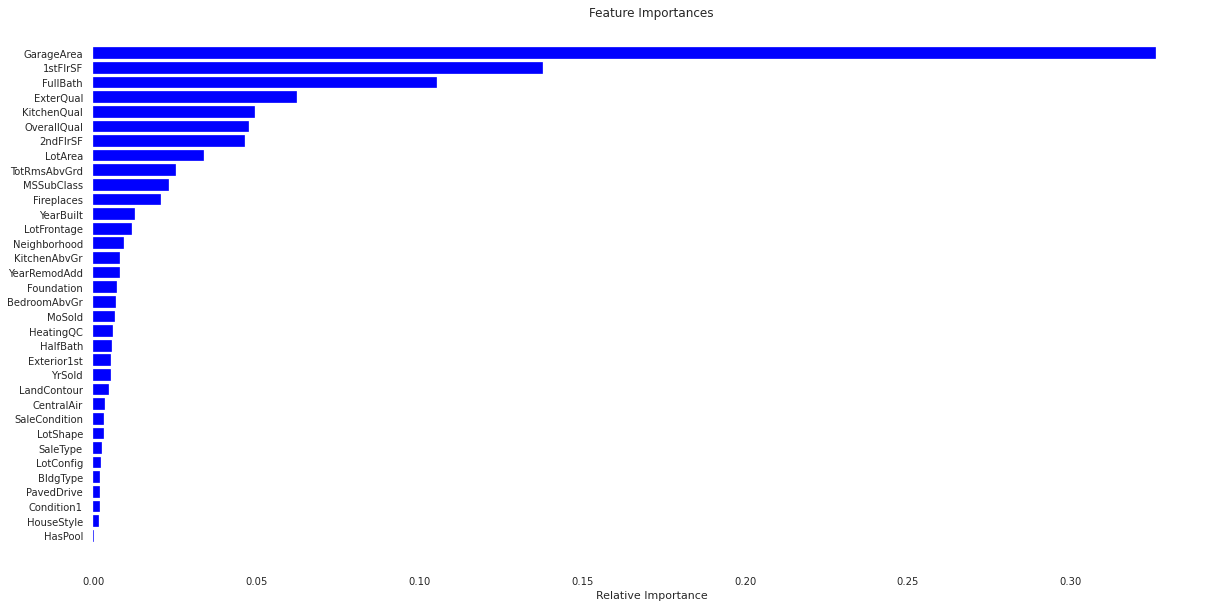

In [27]:
importances = rf.feature_importances_
indices = np.argsort(importances)

plt.rcParams["figure.figsize"] = (20,10)
plt.title('Feature Importances')
plt.barh(range(len(indices)), importances[indices], color='b', align='center')
plt.yticks(range(len(indices)), [all_features[i] for i in indices])
plt.xlabel('Relative Importance')
plt.show()

In [28]:
metrics(test[LABEL], y_pred)

R^2: 0.7881
Mean absolute error: 21542.6360
Mean squared error: 1420949675.4624


**Keras model**

* `Input()` is used to instantiate a Keras tensor.
* `Flatten()`
* `Concatenate()`
* `Dense()`

In [29]:
model_params = {
    'batch_size': 64,
    'epochs': 100,
    'lr': 0.01,
    'dropout': 0.5
}

In [30]:
num_words = min(MAX_NUM_WORDS, len(word_index) + 1)
print('Embedding dimensions will be set as: {}'.format(round(num_words**0.25)))

Embedding dimensions will be set as: 3


In [31]:
def build_model(seq_length, num_length, latent_dim, lr=0.001, dropout=0.2):
    """Build Keras DNN model with Embedding layer.
    """
    # Input layers
    seq_input = Input(shape=[seq_length], dtype='int32', name='text_sequence')
    num_input = Input(shape=(num_length,), name='numerical_features')

    # Embedding layer
    emb = Embedding(input_dim=num_words, output_dim=latent_dim, name='embedding_layer')(seq_input)

    # Flatten embedded output so that we can concatenate with numerical features
    flatten = Flatten(name='flatten_embedded_output')(emb)

    # Concatenate layers
    conc = Concatenate(name='concatenate_embedding_numeric')([flatten, num_input])

    # 1st hidden layer
    h1 = Dense(units=16, activation='relu', name='first_dense_layer')(conc)
    
    # 1st Dropout layer
    d1 = Dropout(rate=dropout, name='first_dropout_layer')(h1)

    # 2nd hidden layer
    h2 = Dense(units=8, activation='relu', name='second_dense_layer')(d1)
    
    # 2nd Dropout layer
    d2 = Dropout(rate=dropout, name='second_dropout_layer')(h2)

    # Output layer
    out = Dense(1, activation='linear', name='output_layer')(d2)

    # Compile model
    model = Model(inputs=[seq_input, num_input], outputs=out)
    model.compile(
        optimizer=Adam(lr=lr),
        loss='mse',
        metrics=['mse', 'mae']
    )
    print(model.summary())
    
    return model


def train_model(model, train, val, label_col, seq_col, num_cols, batch_size=128, epochs=100):
    """Fit model to training set.
    """
    print('[INFO] Batch size: {}, Epochs: {}'.format(batch_size, epochs))
    
    train_input = [
        np.array(train[seq_col].to_list()),
        train[num_cols]
    ]
    
    val_input = [
        np.array(val[seq_col].to_list()),
        val[num_cols]
    ]
    
    print('[INFO] Begin training...')
    history = model.fit(
        x=train_input,
        y=train[label_col],
        validation_data=(val_input, val[label_col]),
        batch_size=batch_size,
        epochs=epochs,
        verbose=1,
        shuffle=True
    )
    
    return history


def plot_loss(model_history):
    """Plot training & validation loss values.
    """
    plt.rcParams["figure.figsize"] = (15,8)
    plt.plot(model_history.history['loss'])
    plt.plot(model_history.history['val_loss'])
    plt.title('Model Loss')
    plt.ylabel('Loss')
    plt.xlabel('Epoch')
    plt.legend(['Train', 'Validation'], loc='upper right')
    plt.show()

In [32]:
model = build_model(
    seq_length=MAX_SEQUENCE_LENGTH,
    num_length=len(all_features),
    latent_dim=int(num_words**0.25),
    lr=model_params['lr'],
    dropout=model_params['dropout']
)

Model: "model"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
text_sequence (InputLayer)      [(None, 6)]          0                                            
__________________________________________________________________________________________________
embedding_layer (Embedding)     (None, 6, 2)         122         text_sequence[0][0]              
__________________________________________________________________________________________________
flatten_embedded_output (Flatte (None, 12)           0           embedding_layer[0][0]            
__________________________________________________________________________________________________
numerical_features (InputLayer) [(None, 34)]         0                                            
______________________________________________________________________________________________

In [33]:
history = train_model(
    model=model,
    train=train,
    val=val,
    label_col=LABEL,
    seq_col='seq',
    num_cols=all_features,
    batch_size=model_params['batch_size'],
    epochs=model_params['epochs']
)

[INFO] Batch size: 64, Epochs: 100
[INFO] Begin training...
Train on 1022 samples, validate on 146 samples
Epoch 1/100
1022/1022 [==============================] - 1s 1ms/sample - loss: 39381098728.4540 - mse: 39381098496.0000 - mae: 181686.2969 - val_loss: 34801010547.7260 - val_mse: 34801012736.0000 - val_mae: 172660.2188
Epoch 2/100
1022/1022 [==============================] - 0s 94us/sample - loss: 39327370927.3425 - mse: 39327367168.0000 - mae: 181534.1406 - val_loss: 34696991196.9315 - val_mse: 34696990720.0000 - val_mae: 172346.4375
Epoch 3/100
1022/1022 [==============================] - 0s 154us/sample - loss: 39110239566.6536 - mse: 39110238208.0000 - mae: 180914.9531 - val_loss: 34343072361.2055 - val_mse: 34343069696.0000 - val_mae: 171275.0625
Epoch 4/100
1022/1022 [==============================] - 0s 126us/sample - loss: 38519480344.0470 - mse: 38519484416.0000 - mae: 179190.6719 - val_loss: 33455791454.6849 - val_mse: 33455790080.0000 - val_mae: 168560.1406
Epoch 5/100


The training loss is higher than the validation loss as dropout is activated when training but deactivated when evaluating on the validation set.

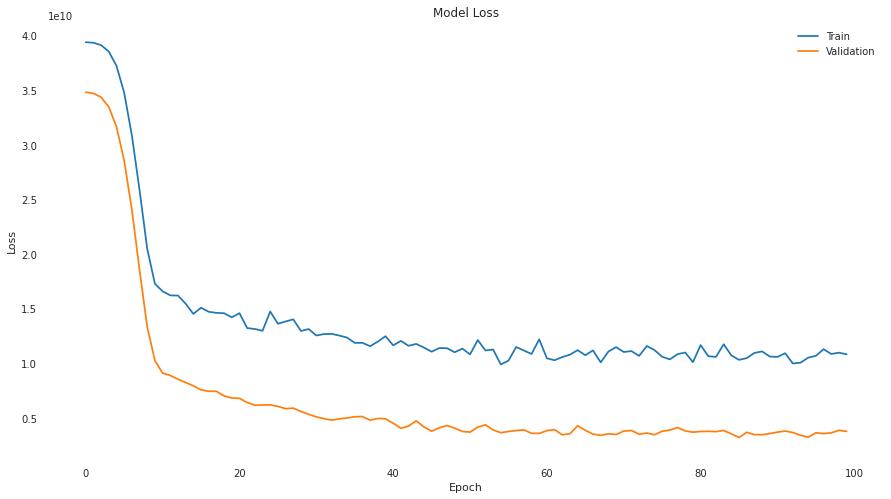

In [34]:
plot_loss(model_history=history)

**Evaluation**

In [35]:
preds = model.predict([
        np.array(test['seq'].to_list()),
        test[all_features]
])

In [36]:
metrics(y_true=test[LABEL], y_pred=preds.reshape(-1,))

R^2: 0.1836
Mean absolute error: 50972.0712
Mean squared error: 5474491869.9309


**Save model**

In [37]:
tf.keras.models.save_model(model, KERAS_PATH)

Instructions for updating:
If using Keras pass *_constraint arguments to layers.
INFO:tensorflow:Assets written to: artifacts/model/assets


## Generate Predictions

Note that this section relies on variables and functions from previous sections.

In [38]:
test_data = pd.read_csv(os.path.join(DATA_PATH, 'test.csv'), header=0)

**Feature subset**

In [39]:
test_data = test_data[feature_subset + ['Id']]
print('The shape of the prediction dataset after taking only a subset of features is {} rows and {} columns.'.format(*test_data.shape))

The shape of the prediction dataset after taking only a subset of features is 1459 rows and 35 columns.


**Feature transformations**

In [40]:
# load pickle files
feature_maps = pickle_load(MAP_PATH)
scalers = pickle_load(SCALER_PATH)
tokenizer = pickle_load(TOKENIZER_PATH)

In [41]:
# new features
test_data['HasPool'] = test_data['PoolArea'].apply(lambda x: 1 if x > 0 else 0)
del test_data['PoolArea']

In [42]:
# imputation
test_data = test_data.fillna(value=values_na)

In [43]:
# boolean transformation
test_data['CentralAir'] = test_data['CentralAir'].apply(lambda x: 1 if x == 'Y' else 0)

In [44]:
# prepare embedding text
test_data[EMB_TEXT] = test_data.apply(lambda x: prepare_emb_text(x, emb_features), axis=1)

# encode sequence
test_sequences = tokenizer.texts_to_sequences(test_data[EMB_TEXT].values)

# pad sequences so that they are all of equal length (MAX_SEQUENCE_LENGTH)
test_emb_texts = pad_sequences(test_sequences, maxlen=MAX_SEQUENCE_LENGTH)
test_data['seq'] = test_emb_texts.tolist()
display(test_data[[EMB_TEXT, 'seq']].head(3))

,emb_text,seq
0,names 1fam feedr vinylsd inside,"[0, 6, 2, 18, 4, 3]"
1,names 1fam norm wd sdng corner,"[6, 2, 1, 9, 10, 5]"
2,gilbert 1fam norm vinylsd inside,"[0, 19, 2, 1, 4, 3]"


In [45]:
test_data[test_data['MSSubClass'] == 150]

,MSSubClass,LotFrontage,LotArea,LotShape,LandContour,LotConfig,Neighborhood,Condition1,BldgType,HouseStyle,...,GarageArea,PavedDrive,YrSold,MoSold,SaleType,SaleCondition,Id,HasPool,emb_text,seq
1358,150,0.0,1700,Reg,HLS,Inside,ClearCr,Norm,Twnhs,1.5Fin,...,450.0,Y,2006,4,WD,Normal,2819,0,clearcr twnhs norm vinylsd inside,"[0, 37, 32, 1, 4, 3]"


In [46]:
# 'UNK' will always be encoded to 0
def map_features(df, cat_feats, feature_maps):
    for field in cat_feats:
        print('[INFO] Mapping: {}'.format(field))
        df[field] = df[field].map(lambda x: feature_maps[field].get(x, 0))
    return df

test_data = map_features(test_data, cat_features, feature_maps)

[INFO] Mapping: MSSubClass
[INFO] Mapping: LotShape
[INFO] Mapping: LandContour
[INFO] Mapping: LotConfig
[INFO] Mapping: Neighborhood
[INFO] Mapping: Condition1
[INFO] Mapping: BldgType
[INFO] Mapping: HouseStyle
[INFO] Mapping: OverallQual
[INFO] Mapping: YearBuilt
[INFO] Mapping: YearRemodAdd
[INFO] Mapping: Exterior1st
[INFO] Mapping: ExterQual
[INFO] Mapping: Foundation
[INFO] Mapping: HeatingQC
[INFO] Mapping: KitchenQual
[INFO] Mapping: PavedDrive
[INFO] Mapping: YrSold
[INFO] Mapping: MoSold
[INFO] Mapping: SaleType
[INFO] Mapping: SaleCondition


In [47]:
# scale features
test_data, _ = scale_features(test_data, cont_features, train=False, scalers=scalers)

**Generate predictions**

In [48]:
# load model
reg_model = tf.keras.models.load_model(KERAS_PATH)
print(reg_model.summary())

Model: "model"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
text_sequence (InputLayer)      [(None, 6)]          0                                            
__________________________________________________________________________________________________
embedding_layer (Embedding)     (None, 6, 2)         122         text_sequence[0][0]              
__________________________________________________________________________________________________
flatten_embedded_output (Flatte (None, 12)           0           embedding_layer[0][0]            
__________________________________________________________________________________________________
numerical_features (InputLayer) [(None, 34)]         0                                            
______________________________________________________________________________________________

In [49]:
# generate predictions
predictions = reg_model.predict([
        np.array(test_data['seq'].to_list()),
        test_data[all_features]
])

In [50]:
print('[INFO] Minimum prediction: {}'.format(predictions.min()))
print('[INFO] Maximum prediction: {}'.format(predictions.max()))
print('[INFO] Mean prediction: {}'.format(predictions.mean()))
print('[INFO] Standard deviation of predictions: {}'.format(predictions.std()))

[INFO] Minimum prediction: 46495.7421875
[INFO] Maximum prediction: 308891.6875
[INFO] Mean prediction: 135044.40625
[INFO] Standard deviation of predictions: 48814.0234375


In [51]:
# create dictionary of predictions where key is the house ID
predictions_dict = dict(zip(test_data['Id'].values, predictions.reshape(-1,)))
print('Example prediction for ID {}: ${:.2f}'.format(1461, predictions_dict[1461]))

Example prediction for ID 1461: $108563.36


In [52]:
# save predictions as pickle
PREDICTION_PATH = 'predictions.pkl'
pickle_dump(PREDICTION_PATH, predictions_dict)

In [54]:
# ! gsutil cp predictions.pkl gs://laxmi-prajapat-sandbox/house-prices-regression/
# ! gsutil -m cp -r artifacts/model gs://laxmi-prajapat-sandbox/house-prices-regression/model
# ! gsutil cp artifacts/*.pkl gs://laxmi-prajapat-sandbox/house-prices-regression/artifacts

Copying file://predictions.pkl [Content-Type=application/octet-stream]...
/ [1 files][ 82.1 KiB/ 82.1 KiB]                                                
Operation completed over 1 objects/82.1 KiB.                                     
Copying file://artifacts/model/saved_model.pb [Content-Type=application/octet-stream]...
Copying file://artifacts/model/variables/variables.index [Content-Type=application/octet-stream]...
Copying file://artifacts/model/variables/variables.data-00000-of-00001 [Content-Type=application/octet-stream]...
/ [3/3 files][180.7 KiB/180.7 KiB] 100% Done                                    
Operation completed over 3 objects/180.7 KiB.                                    
Copying file://artifacts/feature_maps.pkl [Content-Type=application/octet-stream]...
Copying file://artifacts/scaler.pkl [Content-Type=application/octet-stream]...  
Copying file://artifacts/tokenizer.pkl [Content-Type=application/octet-stream]...
/ [3 files][ 14.7 KiB/ 14.7 KiB]                 